In [114]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

from datetime import datetime




In [115]:
#Define paths
currentDir = os.getcwd()
accelerometerDataPath = os.path.join(currentDir, "data", "all_accelerometer_data_pids_13.csv")
tacDataPath = os.path.join(currentDir, "data", "clean_tac")
phoneTypesPath = os.path.join(currentDir, "data", "phone_types.csv")

In [116]:
#Combine clean_tac into one dataframe
csvFiles = glob.glob(os.path.join(tacDataPath, '*.csv'))
print(csvFiles)
tacDataFrames = []

for csvFile in csvFiles:
    tacDataFrames.append(pd.read_csv(csvFile))

['c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BK7610_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\BU4707_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\CC6740_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DC6359_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\DK3500_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\HV0618_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JB3156_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\JR8022_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive\\Documents\\GitHub\\MLProject\\project\\data\\clean_tac\\MC7070_clean_TAC.csv', 'c:\\Users\\heath\\OneDrive

In [117]:
#Loading data files

tacData = pd.concat(tacDataFrames, ignore_index=True)
accelerometerData = pd.read_csv(accelerometerDataPath)
phoneTypes = pd.read_csv(phoneTypesPath)

In [118]:
#Check dataframes
tacData.head()
accelerometerData.head()
phoneTypes.head()


pid phonetype
0  BK7610    iPhone
1  BU4707    iPhone
2  CC6740   Android
3  DC6359    iPhone
4  DK3500    iPhone

In [119]:
#Check for null
tacData.isnull().sum()
accelerometerData.isnull().sum()
phoneTypes.isnull().sum()

pid          0
phonetype    0
dtype: int64

In [120]:
print(tacData)

      timestamp  TAC_Reading
0    1493718714    -0.000482
1    1493720697     0.001573
2    1493721027     0.002144
3    1493721357     0.000877
4    1493721686    -0.001145
..          ...          ...
710  1493797974     0.029049
711  1493799820     0.016286
712  1493801652     0.004243
713  1493803481    -0.001995
714  1493805310    -0.002919

[715 rows x 2 columns]


In [121]:
#Connect accelerometer data with their respective phone types
accelerometerData = accelerometerData.merge(phoneTypes, on='pid')
print(accelerometerData)

                  time     pid         x         y         z phonetype
0                    0  JB3156  0.000000  0.000000  0.000000   Android
1                    0  CC6740  0.000000  0.000000  0.000000   Android
2        1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3        1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4        1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                ...     ...       ...       ...       ...       ...
1048570  1493742311425  JB3156 -0.790259 -0.879167 -0.254394   Android
1048571  1493742311430  HV0618 -0.036200 -0.085200  0.005500    iPhone
1048572  1493742311430  BK7610 -0.217200 -0.184400 -0.434500    iPhone
1048573  1493742311433  SF3079  0.030300  0.098100  0.098000    iPhone
1048574  1493742311440  CC6740  0.020966 -0.010933  0.145366   Android

[1048575 rows x 6 columns]


In [122]:
#Identify bar crawl events (increased movement)
segmentLength = 60
barCrawlEvents = []

tacData['timestamp'] *= 1000
print(tacData)

print(accelerometerData)

         timestamp  TAC_Reading
0    1493718714000    -0.000482
1    1493720697000     0.001573
2    1493721027000     0.002144
3    1493721357000     0.000877
4    1493721686000    -0.001145
..             ...          ...
710  1493797974000     0.029049
711  1493799820000     0.016286
712  1493801652000     0.004243
713  1493803481000    -0.001995
714  1493805310000    -0.002919

[715 rows x 2 columns]
                  time     pid         x         y         z phonetype
0                    0  JB3156  0.000000  0.000000  0.000000   Android
1                    0  CC6740  0.000000  0.000000  0.000000   Android
2        1493733882409  SA0297  0.075800  0.027300 -0.010200    iPhone
3        1493733882455  SA0297 -0.035900  0.079400  0.003700    iPhone
4        1493733882500  SA0297 -0.242700 -0.086100 -0.016300    iPhone
...                ...     ...       ...       ...       ...       ...
1048570  1493742311425  JB3156 -0.790259 -0.879167 -0.254394   Android
1048571  1493742311430  

In [161]:
# Initialize an empty DataFrame to store all participants' data
all_participants_data = pd.DataFrame(columns=accelerometerData.columns)

# Iterate through participants data
for participant_id, participant_data in accelerometerData.groupby('pid'):
    # Calculate magnitude for each participant
    participant_data['magnitude'] = np.sqrt(participant_data['x']**2 + participant_data['y']**2 + participant_data['z']**2)
    
    # Check if participant_data contains any valid entries
    if not participant_data.empty and not participant_data.isnull().all().all():
        # Append participant data to the DataFrame containing all participants' data
        all_participants_data = pd.concat([all_participants_data, participant_data], ignore_index=True)

# Define threshold
threshold = .01  # Adjust threshold value as needed

# Identify segments
segments = []
segment_start = None
current_id = None

for index, row in all_participants_data.iterrows():
    if row['magnitude'] > threshold:
        if segment_start is None:
            segment_start = row['time']
            current_id = row['pid']
    else:
        if segment_start is not None:
            segment_end = row['time']
            segments.append((current_id, segment_start, segment_end))
            segment_start = None
            current_id = None

# Create DataFrame for segments
barCrawlEventsDf = pd.DataFrame(segments, columns=['pid', 'segment_start', 'segment_end'])

print(participant_data)
print(barCrawlEventsDf)

C:\Users\heath\AppData\Local\Temp\ipykernel_31792\662344411.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_participants_data = pd.concat([all_participants_data, participant_data], ignore_index=True)


                  time     pid       x       y       z phonetype  magnitude
437429   1493739196712  SF3079 -0.0044  0.0075  0.0109    iPhone   0.013943
437434   1493739196737  SF3079 -0.0055  0.0093  0.0093    iPhone   0.014256
437439   1493739196761  SF3079 -0.0024  0.0121  0.0074    iPhone   0.014385
437443   1493739196787  SF3079  0.0066  0.0012  0.0067    iPhone   0.009481
437449   1493739196811  SF3079  0.0104  0.0035  0.0067    iPhone   0.012857
...                ...     ...     ...     ...     ...       ...        ...
1048550  1493742311327  SF3079  0.0296 -0.0074  0.0064    iPhone   0.031175
1048559  1493742311369  SF3079  0.0108 -0.0031 -0.0358    iPhone   0.037522
1048563  1493742311385  SF3079  0.0314  0.0440 -0.0248    iPhone   0.059473
1048569  1493742311415  SF3079  0.0621  0.0845  0.0441    iPhone   0.113761
1048573  1493742311433  SF3079  0.0303  0.0981  0.0980    iPhone   0.141936

[123166 rows x 7 columns]
          pid  segment_start    segment_end
0      BK7610  14

In [162]:
# Define the TAC threshold
tacThreshold_withThresh = 0.08

# Define tolerance in milliseconds
tolerance_ms = 60 * 10**9  # Adjust tolerance as needed

# Merge barCrawlEventsDF with tacdata based on timestamps
merged_data = pd.merge_asof(barCrawlEventsDf.sort_values('segment_start'), 
                            tacData.sort_values('timestamp'),
                            left_on='segment_start', 
                            right_on='timestamp', 
                            direction='nearest',
                            tolerance=tolerance_ms)

# Filter the merged data to include only rows where the TAC reading is above the threshold
filtered_data_above_threshold = merged_data[merged_data['TAC_Reading'] >= tacThreshold_withThresh]
filtered_data_below_threshold = merged_data[merged_data['TAC_Reading'] < tacThreshold_withThresh]
filtered_aboveMergeData = merged_data[merged_data['TAC_Reading'] >= 0]

filtered_aboveMergeData['phonetypes'] = phoneTypes['phonetype']
filtered_participant_data = participant_data[participant_data['magnitude'] >= 1]
filtered_aboveMergeData = pd.merge(filtered_aboveMergeData, filtered_participant_data[['pid', 'magnitude']], on='pid', how='left')



# Print the counts
above_count = filtered_data_above_threshold.shape[0]
below_count = filtered_data_below_threshold.shape[0]

print("Number of bar crawl events above 0.08 TAC readings:", above_count)
print("Number of bar crawl events below 0.08 TAC readings:", below_count)

# Determine which category occurs more frequently
if above_count > below_count:
    print("Bar crawl events above 0.08 TAC readings occur more frequently.")
elif above_count < below_count:
    print("Bar crawl events below 0.08 TAC readings occur more frequently.")
else:
    print("Bar crawl events above and below 0.08 TAC readings occur with equal frequency.")

C:\Users\heath\AppData\Local\Temp\ipykernel_31792\3521008784.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_aboveMergeData['phonetypes'] = phoneTypes['phonetype']


Number of bar crawl events above 0.08 TAC readings: 5150
Number of bar crawl events below 0.08 TAC readings: 23406
Bar crawl events below 0.08 TAC readings occur more frequently.


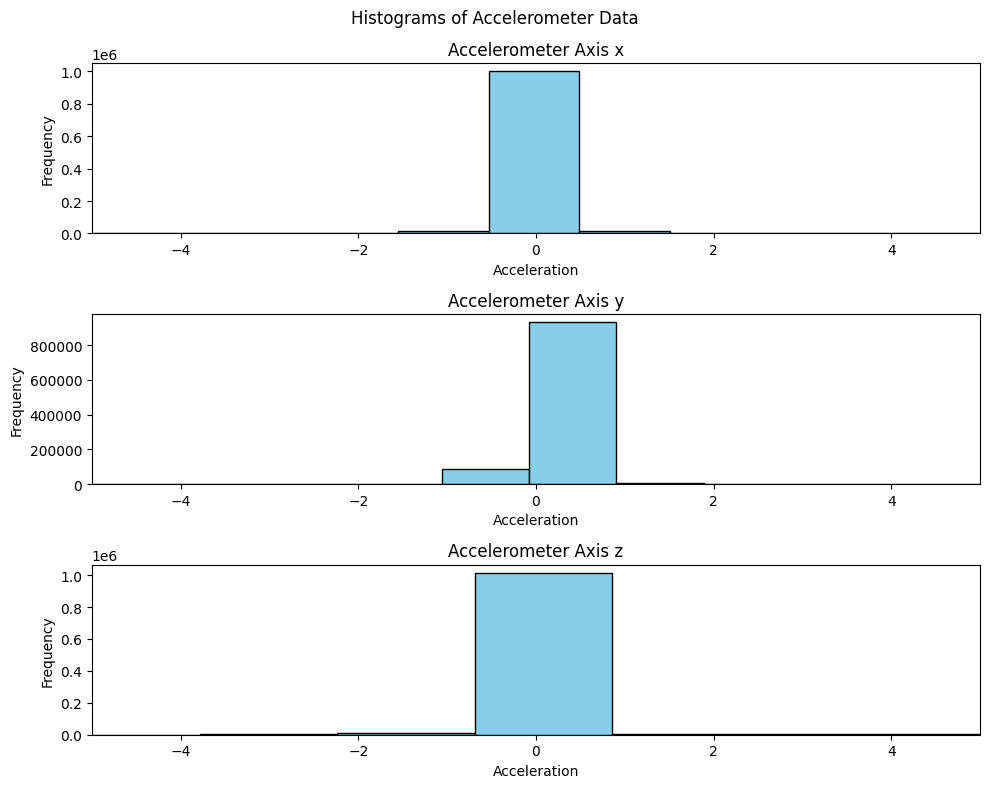

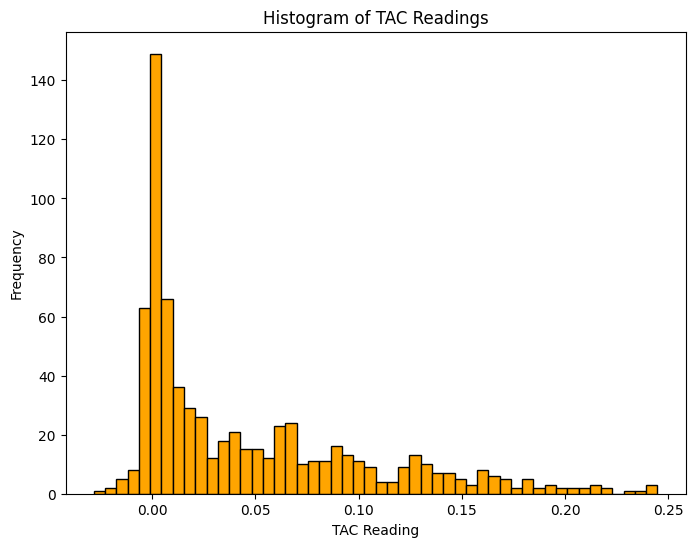

In [163]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

#Plot histograms
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].hist(accelerometerData[axis], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Acceleration')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(-5, 5)

plt.tight_layout()
plt.show()

#TAC histogram
plt.figure(figsize=(8, 6))
plt.hist(tacData['TAC_Reading'], bins=50, color='orange', edgecolor='black')
plt.title('Histogram of TAC Readings')
plt.xlabel('TAC Reading')
plt.ylabel('Frequency')
plt.show()

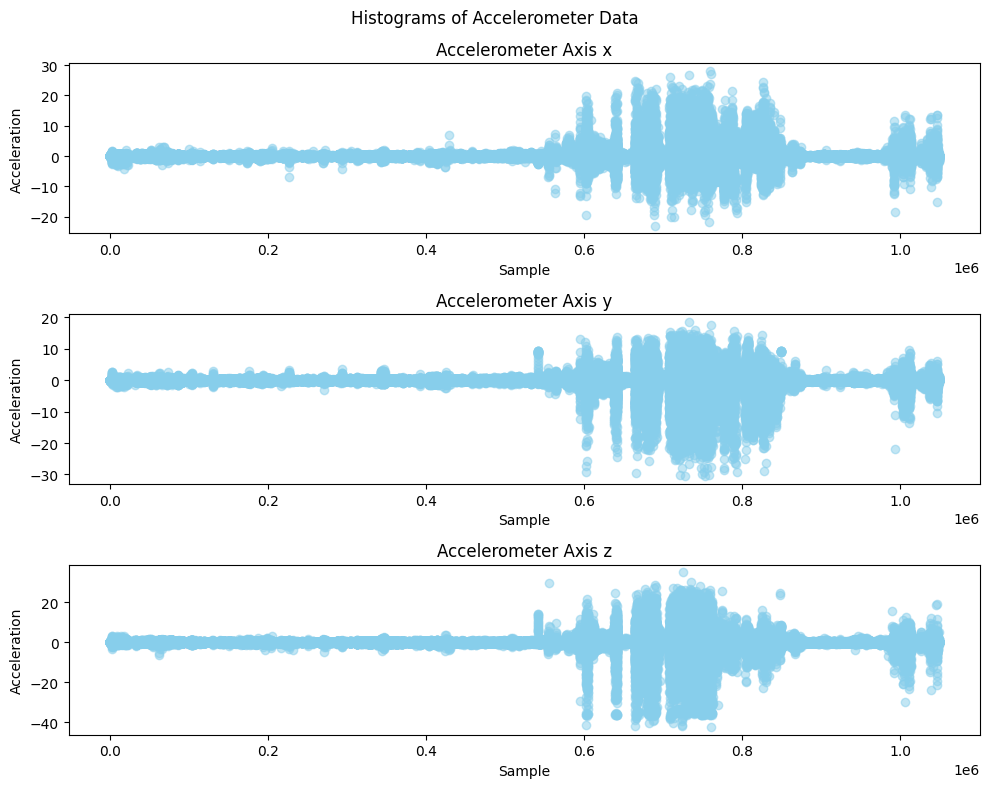

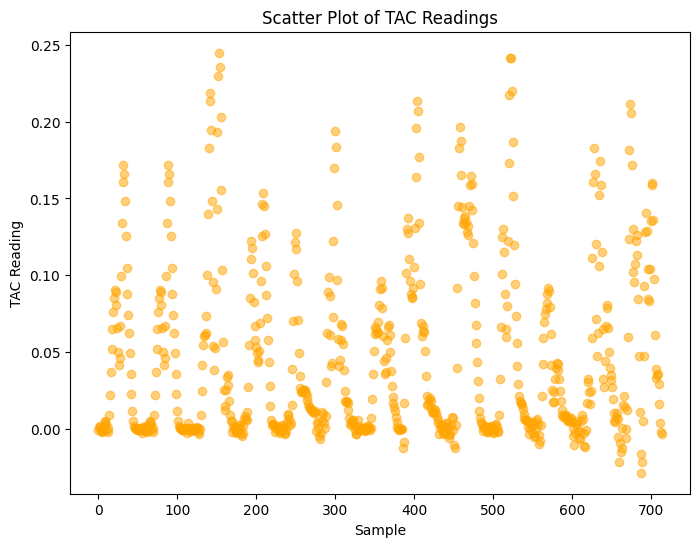

In [164]:
#Set up the figure
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.suptitle('Histograms of Accelerometer Data')

# Plot scatter plots for accelerometer data
for i, axis in enumerate(['x', 'y', 'z']):
    axs[i].scatter(range(len(accelerometerData[axis])), accelerometerData[axis], color='skyblue', alpha=0.5)
    axs[i].set_title(f'Accelerometer Axis {axis}')
    axs[i].set_xlabel('Sample')
    axs[i].set_ylabel('Acceleration')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(len(tacData['TAC_Reading'])), tacData['TAC_Reading'], color='orange', alpha=0.5)
plt.title('Scatter Plot of TAC Readings')
plt.xlabel('Sample')
plt.ylabel('TAC Reading')
plt.show()

In [165]:
# Calculate total time for each segment in the filtered data where TAC readings are above the threshold
filtered_aboveMergeData['total_time'] = filtered_aboveMergeData['segment_end'] - filtered_aboveMergeData['segment_start']

# Calculate total time for each segment in the filtered data where TAC readings are below the threshold
filtered_data_below_threshold['total_time'] = filtered_data_below_threshold['segment_end'] - filtered_data_below_threshold['segment_start']

# Print the columns of filtered_aboveMergeData to verify the addition of the 'total_time' column
print(filtered_aboveMergeData.columns)

# Select features (X) and target variable (y) for modeling
X = filtered_aboveMergeData[['total_time', 'TAC_Reading']]
y = (filtered_aboveMergeData['TAC_Reading'] >= 0.08)

# Print the features (X) and target variable (y)
print("Features (X) for segments with TAC readings above threshold:")
print(X)
print("\nTarget variable (y) for segments with TAC readings above threshold:")
print(y)

Index(['pid', 'segment_start', 'segment_end', 'timestamp', 'TAC_Reading',
       'phonetypes', 'magnitude', 'total_time'],
      dtype='object')
Features (X) for segments with TAC readings above threshold:
            total_time  TAC_Reading
0                 8408     0.003425
1                  405     0.003425
2                 1716     0.003425
3                   44     0.003425
4                  180     0.003425
...                ...          ...
4588912            165     0.040862
4588913            165     0.040862
4588914            165     0.040862
4588915            201     0.040862
4588916 -1493742308673     0.040862

[4588917 rows x 2 columns]

Target variable (y) for segments with TAC readings above threshold:
0          False
1          False
2          False
3          False
4          False
           ...  
4588912    False
4588913    False
4588914    False
4588915    False
4588916    False
Name: TAC_Reading, Length: 4588917, dtype: bool


C:\Users\heath\AppData\Local\Temp\ipykernel_31792\3583699820.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_below_threshold['total_time'] = filtered_data_below_threshold['segment_end'] - filtered_data_below_threshold['segment_start']


In [166]:
#Handle any NA 
X = X.fillna(X.mean())

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training features (X_train):", X_train.shape)
print("Shape of testing features (X_test):", X_test.shape)
print("Shape of training target variable (y_train):", y_train.shape)
print("Shape of testing target variable (y_test):", y_test.shape)

# Initialize and fit the linear regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)

# Evaluate the model
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

print("Train R^2 score:", train_score)
print("Test R^2 score:", test_score)

Shape of training features (X_train): (3671133, 2)
Shape of testing features (X_test): (917784, 2)
Shape of training target variable (y_train): (3671133,)
Shape of testing target variable (y_test): (917784,)
Coefficients: [3.55703321e-14 6.69475717e+00]
Intercept: -0.13788820432843485
Train R^2 score: 0.6929817697665512
Test R^2 score: 0.6925687749879186


In [168]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_reg = LogisticRegression()

logistic_reg.fit(X_train, y_train)

y_pred = logistic_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9989627188968211


In [179]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define your preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('pid', OneHotEncoder(handle_unknown='ignore'), ['pid'])
    ],
    remainder='passthrough'
)

# Define the pipeline with the preprocessor and the RandomForestClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # You can adjust parameters as needed
])

X = filtered_aboveMergeData[['phonetypes', 'pid', 'magnitude']]
y = (filtered_aboveMergeData['TAC_Reading'] >= .08)

label_encoder = LabelEncoder()
X['phonetypes_encoded'] = label_encoder.fit_transform(X['phonetypes'])

# Assuming X and y are defined as you have them
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


KeyError: 'phonetypes'

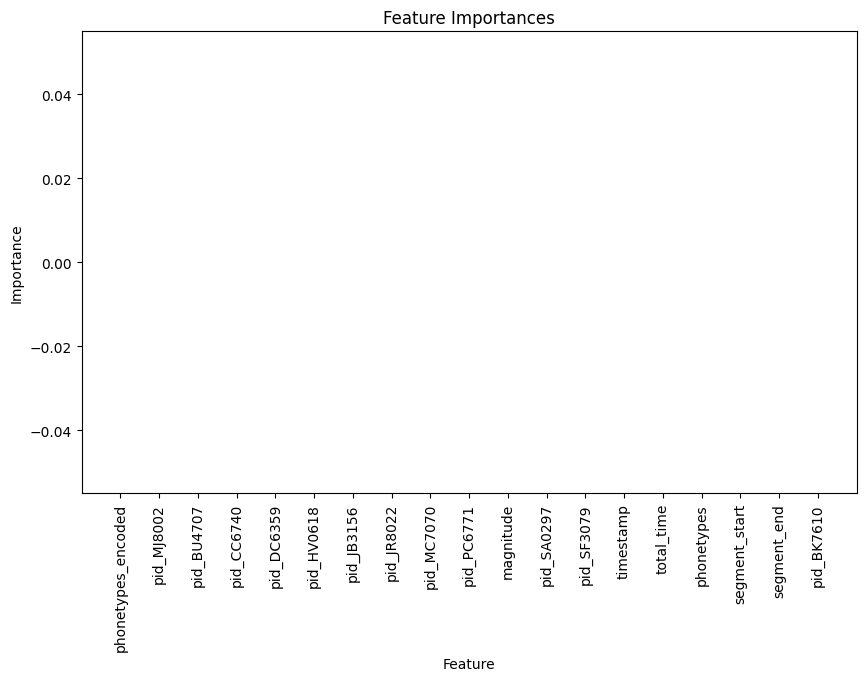

In [176]:
import matplotlib.pyplot as plt

random_forest = pipeline.named_steps['classifier']

feature_importances = random_forest.feature_importances_

one_hot_feature_names = preprocessor.named_transformers_['pid'].get_feature_names_out(input_features=['pid'])

remaining_feature_names = list(X.columns.drop('pid'))

feature_names = list(one_hot_feature_names) + remaining_feature_names

indices = feature_importances.argsort()[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), feature_importances[indices], align="center")
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()